<a href="https://colab.research.google.com/github/Chiaradisanto/Segmentation/blob/main/Sensor_AMILOIDOSIipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
import os
import numpy as np
from matplotlib import pyplot as plt
batch_size=3

In [4]:
seed=24
batch_size=3
n_classes=1
from tensorflow.keras.preprocessing.image import ImageDataGenerator




#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
def trainGenerator(train_img_path, train_mask_path):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',shear_range=0.5, 
                      rotation_range=50,
                      zoom_range=0.2,
                      width_shift_range=0.2, height_shift_range=0.2,
            
                      rescale=1/255.)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
   
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        color_mode = 'grayscale',
        target_size=(512,512),
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None ,
        color_mode = 'grayscale',
        target_size=(512,512),
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    return train_generator

In [5]:
train_img_path = "/gdrive/MyDrive/TESI/output/train/train_images"
train_mask_path = "/gdrive/MyDrive/TESI/output/train/train_masks"
train_img_gen = trainGenerator(train_img_path, train_mask_path)

val_img_path = "/gdrive/MyDrive/TESI/output/train/val_images"
val_mask_path = "/gdrive/MyDrive/TESI/output/train/val_masks"
val_img_gen = trainGenerator(val_img_path, val_mask_path)

Found 2960 images belonging to 1 classes.
Found 2960 images belonging to 1 classes.
Found 320 images belonging to 1 classes.
Found 320 images belonging to 1 classes.


In [6]:

x, y = train_img_gen.__next__()
x_val, y_val= val_img_gen.__next__()

In [7]:
batch_size

3

In [8]:
print(y.size)
print(x.size)
print("max value in image dataset is: ", x.max())

786432
786432
max value in image dataset is:  1.0


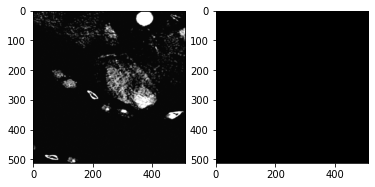

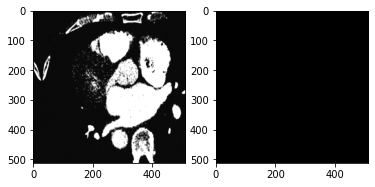

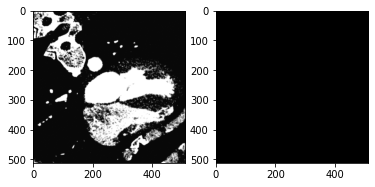

In [9]:


for i in range(0,3):
    image = x[i,:,:,0]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [10]:
print(x.shape)
print(y.shape)
print("max value in image dataset is: ", y.max())

(3, 512, 512, 1)
(3, 512, 512, 1)
max value in image dataset is:  1.0


In [11]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('/gdrive/MyDrive/TESI/output/train/train_images/images'))
num_val_images = len(os.listdir('/gdrive/MyDrive/TESI/output/train/val_images/images'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]
input_shape = (3,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(3, 512, 512, 1)


In [12]:

time_steps = 3
img_height = 512
img_width = 512
channels = 1

In [13]:
from tensorflow.keras.layers import Conv2D, TimeDistributed,Dropout,Input, Dense,\
    BatchNormalization, GRU, Layer, Flatten,MaxPooling2D, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras import layers
from keras import models
import tensorflow as tf

In [15]:
print(val_steps_per_epoch)

106


In [17]:
input_l = layers.Input(shape=(time_steps,img_height, img_width,channels))
x =  (layers.TimeDistributed(layers.Conv2D( 64, kernel_size=(3, 3),padding='same',strides=(1,1) ))) (input_l)
conv2 = layers.TimeDistributed( layers.Conv2D( 64, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (x)
x=layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2)))(conv2)
x = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (x)
conv5 = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (x)
x=layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2)))(conv5)
x = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (x)
conv8 = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (x)
x=layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2)))(conv8)
x=layers.Bidirectional(layers.ConvLSTM2D(256,kernel_size=(3,3),padding='same',strides=(1,1),return_sequences=True))(x)
up1 = layers.TimeDistributed( layers.Conv2DTranspose( 512,kernel_size=(3,3),padding='same',strides=(2,2)))(x)
concat1 = layers.concatenate([up1, conv8])
x = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (concat1)
x = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (x)
up2 = layers.TimeDistributed( layers.Conv2DTranspose( 256,kernel_size=(3,3),padding='same',strides=(2,2)))(x)
concat2 = layers.concatenate([up2, conv5])
x = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (concat2)
x = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (x)
up3 = layers.TimeDistributed( layers.Conv2DTranspose( 128,kernel_size=(3,3),padding='same',strides=(2,2)))(x)
concat3 = layers.concatenate([up3, conv2])
x = layers.TimeDistributed( layers.Conv2D( 64, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (concat3)
x=layers.Bidirectional(layers.ConvLSTM2D(32,kernel_size=(3,3),padding='same',strides=(1,1),return_sequences=True))(x)
out = tf.reshape(x, (-1, 1, 512,512, 64))
#out= layers.TimeDistributed( layers.Conv2D( 64, kernel_size=(1, 1),padding='same',strides=(1,1) ) ) (out)


model = models.Model(inputs=input_l, outputs=out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3, 512, 512  0           []                               
                                , 1)]                                                             
                                                                                                  
 time_distributed_17 (TimeDistr  (None, 3, 512, 512,  640        ['input_2[0][0]']                
 ibuted)                         64)                                                              
                                                                                                  
 time_distributed_18 (TimeDistr  (None, 3, 512, 512,  36928      ['time_distributed_17[0][0]']    
 ibuted)                         64)                                                        

In [18]:
from keras import backend as K
smooth=1

In [19]:
from keras import backend as K
def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [20]:
model.compile( optimizer=Adam(1e-4), loss=[dice_coef_loss], metrics=[dice_coef])

In [21]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=30,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

Epoch 1/30
985/986 [============================>.] - ETA: 4s - loss: 0.8069 - dice_coef: 0.1931

InvalidArgumentError: ignored

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Sensor3D-Amiloidosi-accuracy.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [ ]:
from keras import backend as K
def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Recall, Precision

In [ ]:
model.compile(optimizer=Adam(1e-4), loss=dice_coef_loss, metrics=dice_coef)


In [ ]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=val_img_gen,

    
          validation_steps=val_steps_per_epoch)

Epoch 1/10
977/986 [============================>.] - ETA: 12s - loss: 0.8080 - dice_coef: 0.1920

InvalidArgumentError: ignored

In [ ]:
model.save('/gdrive/MyDrive/TESI/Sensor3D-Amiloidosi-accuracy.h5')